# Hybrid quantum-classical auto encoder 

In [ ]:
"""
Sophie Choe 9/27/2019

Keras-pennylane implementation of the hybrid quantum-classical auto encoder proposed in 
"Continous-variable quantum neural networks"
The loss function MSE used here is not true to the paper, since the state vector retrieval functionality
is not supported by Pennylane yet.
"""

Dependencies: keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# ===================================================================================
#                       Create Data
# ===================================================================================

num_train = 100
num_test = 20
len_vector = 3

np.random.seed(1)
x_train = np.random.rand(num_train, len_vector)
x_test = np.random.rand(num_test, len_vector)

In [4]:
# ===================================================================================
#                       Classical Layers using Keras Sequential
# ===================================================================================

# Define first layer, hidden layers, and output layer with the output of two neurons

keras.backend.set_floatx('float32')
model = tf.keras.Sequential(
                            [layers.Dense(5, input_shape=(3,), activation ="elu"),
                             layers.Dense(5, activation ="elu"),
                             layers.Dense(5, activation ="elu"),
                             layers.Dense(5, activation ="elu"),
                             layers.Dense(5, activation ="elu"),
                             layers.Dense(5, activation ="elu"),
                             layers.Dense(2, activation ="elu")]
                            )

In [5]:
# ===================================================================================
#                                Quantum Iterative Layer
# ===================================================================================

# Initialize weights to pass through the q_layer function. Tensor of size: num_layers x num_parameters  
# Params for the Rotation gate, Squeezing gate, Displacement gate, and Kerr gate

def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    r1_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    r2_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([r1_weights, s_weights, r2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

# Construct a quantum layer with initialized weights as variables

def q_layer(v):
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)
    qml.Displacement(v[3], 0.0, wires=0)
    qml.Kerr(v[4], wires=0)

In [6]:
# ===================================================================================
#                                Quantum Circuit
# ===================================================================================

# Use the output of the classical layers to initialize the quantum layers with the Displacement gate
# Iterate the quantum layers

num_modes = 1
num_basis = 3

dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=num_basis) # select a devide 

@qml.qnode(dev, interface = "tf")
def quantum_nn(inputs, var):
    
    # Inputs: the output of classical layers as displacement gate parameters
    qml.Displacement(inputs[0], inputs[1], wires=0)    

    # quantum layers
    for v in var:
        q_layer(v)

    return qml.probs(wires=0)

In [7]:
# ===================================================================================
#                             Hybrid Model
# ===================================================================================

"""
Add the quantum layer to the classical to create a hybrid model
    1. initialize weights for quantum layers
    2. create a dictionary of weight shape to pass as one of the variables to covert to keras layer
    3. convert the quantum layer to a Keras layer
    4. add to the classical sequential model
"""

num_layers = 25
num_modes = 1

weigths = init_weights(num_layers, num_modes)
shape_tup = weigths.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim=4)
model.add(qlayer)

In [8]:
# ===================================================================================
#                                    Training
# ===================================================================================

opt = keras.optimizers.Adam(learning_rate=0.01)   # try lr = 0.005 and lr = 0.3

model.compile(opt, loss = "MSE", metrics = ['accuracy'])

history = model.fit(x_train, 
                    x_train,
                    epochs = 200,
                    batch_size = 24,
                    shuffle = True,
                    validation_data=(x_test, x_test))

Epoch 1/200
5/5 [==============================] - 172s 32s/step - loss: 0.2658 - accuracy: 0.2813
Epoch 2/200
5/5 [==============================] - 190s 37s/step - loss: 0.2000 - accuracy: 0.2730
Epoch 3/200
5/5 [==============================] - 182s 35s/step - loss: 0.1669 - accuracy: 0.4011
Epoch 4/200
5/5 [==============================] - 179s 35s/step - loss: 0.1624 - accuracy: 0.3754
Epoch 5/200
5/5 [==============================] - 190s 36s/step - loss: 0.1489 - accuracy: 0.4104
Epoch 6/200
5/5 [==============================] - 166s 31s/step - loss: 0.1463 - accuracy: 0.4891
Epoch 7/200
5/5 [==============================] - 164s 31s/step - loss: 0.1355 - accuracy: 0.4383
Epoch 8/200
5/5 [==============================] - 165s 31s/step - loss: 0.1302 - accuracy: 0.4674
Epoch 9/200
5/5 [==============================] - 166s 32s/step - loss: 0.1224 - accuracy: 0.4219
Epoch 10/200
5/5 [==============================] - 171s 32s/step - loss: 0.1181 - accuracy: 0.5149
Epoch 11/

5/5 [==============================] - 3486s 640s/step - loss: 0.0931 - accuracy: 0.8214
Epoch 83/200
5/5 [==============================] - 916s 58s/step - loss: 0.0894 - accuracy: 0.8370
Epoch 84/200
5/5 [==============================] - 305s 57s/step - loss: 0.0916 - accuracy: 0.6988
Epoch 85/200
5/5 [==============================] - 317s 61s/step - loss: 0.0970 - accuracy: 0.7199
Epoch 86/200
5/5 [==============================] - 307s 56s/step - loss: 0.0991 - accuracy: 0.7926
Epoch 87/200
5/5 [==============================] - 3975s 976s/step - loss: 0.0994 - accuracy: 0.7079
Epoch 88/200
5/5 [==============================] - 6432s 1257s/step - loss: 0.0954 - accuracy: 0.8211
Epoch 89/200
5/5 [==============================] - 5326s 914s/step - loss: 0.0891 - accuracy: 0.8059
Epoch 90/200
5/5 [==============================] - 359s 73s/step - loss: 0.0830 - accuracy: 0.8953
Epoch 91/200
5/5 [==============================] - 738s 166s/step - loss: 0.0818 - accuracy: 0.8315
Epo

5/5 [==============================] - 164s 33s/step - loss: 0.0812 - accuracy: 0.9105
Epoch 164/200
5/5 [==============================] - 256s 49s/step - loss: 0.0773 - accuracy: 0.9236
Epoch 165/200
5/5 [==============================] - 264s 52s/step - loss: 0.0794 - accuracy: 0.9159
Epoch 166/200
5/5 [==============================] - 258s 49s/step - loss: 0.0898 - accuracy: 0.8930
Epoch 167/200
5/5 [==============================] - 280s 52s/step - loss: 0.0824 - accuracy: 0.8629
Epoch 168/200
5/5 [==============================] - 285s 54s/step - loss: 0.0865 - accuracy: 0.9076
Epoch 169/200
5/5 [==============================] - 280s 53s/step - loss: 0.0869 - accuracy: 0.8853
Epoch 170/200
5/5 [==============================] - 289s 55s/step - loss: 0.0826 - accuracy: 0.8778
Epoch 171/200
5/5 [==============================] - 254s 48s/step - loss: 0.0843 - accuracy: 0.9074
Epoch 172/200
5/5 [==============================] - 289s 51s/step - loss: 0.0823 - accuracy: 0.8864
Epoc

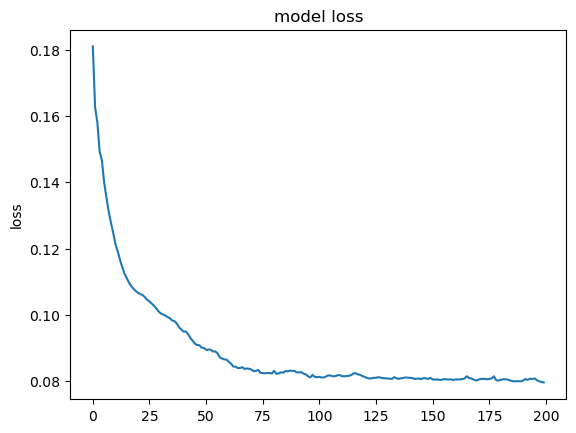

In [9]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(history.history['loss'], '-g')
plt.plot(history.history['val_loss'], '-r')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

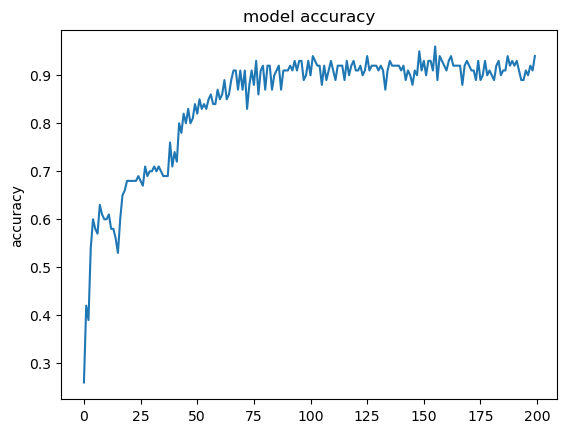

In [10]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(history.history['accuracy'], '-g')
plt.plot(history.history['val_accuracy'], '-r')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()